In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sentence_transformers import SentenceTransformer, util

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# understand the distribution of songs attributes
songs_set = pd.read_csv('../songsdata/cleaned_data/cleaned_songs.csv') ; songs_set.head(2)

,artist,title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,duration,time_signature,lyrics,genius_id,annotation,lyrics_list,line_len,song_len
0,A Few Good Men,Tonite,0.615,0.673,5.0,-8.501,0.0,0.1150,0.0429,0.0,...,0.831,178.124,254360.0,4.0,Tonite LyricsYou know I really want to love yo...,1382268.0,[],['Tonite LyricsYou know I really want to love ...,6.666667,66
1,A Few Good Men,Have I Never,0.717,0.377,4.0,-8.680,1.0,0.0288,0.2820,0.0,...,0.161,120.036,336533.0,4.0,Have I Never LyricsHave I never told you I lov...,1187594.0,[],['Have I Never LyricsHave I never told you I l...,8.196078,51


In [3]:
songs_set.columns

Index(['artist', 'title', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration', 'time_signature', 'lyrics', 'genius_id',
       'annotation', 'lyrics_list', 'line_len', 'song_len'],
      dtype='object')

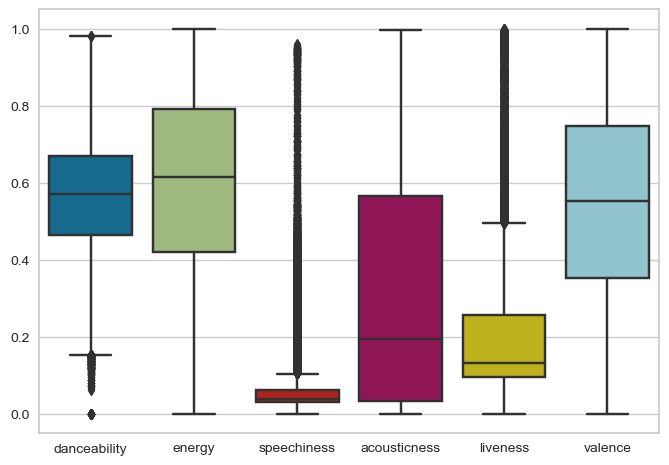

In [4]:
sns.boxplot(data=songs_set[['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']])
plt.show()

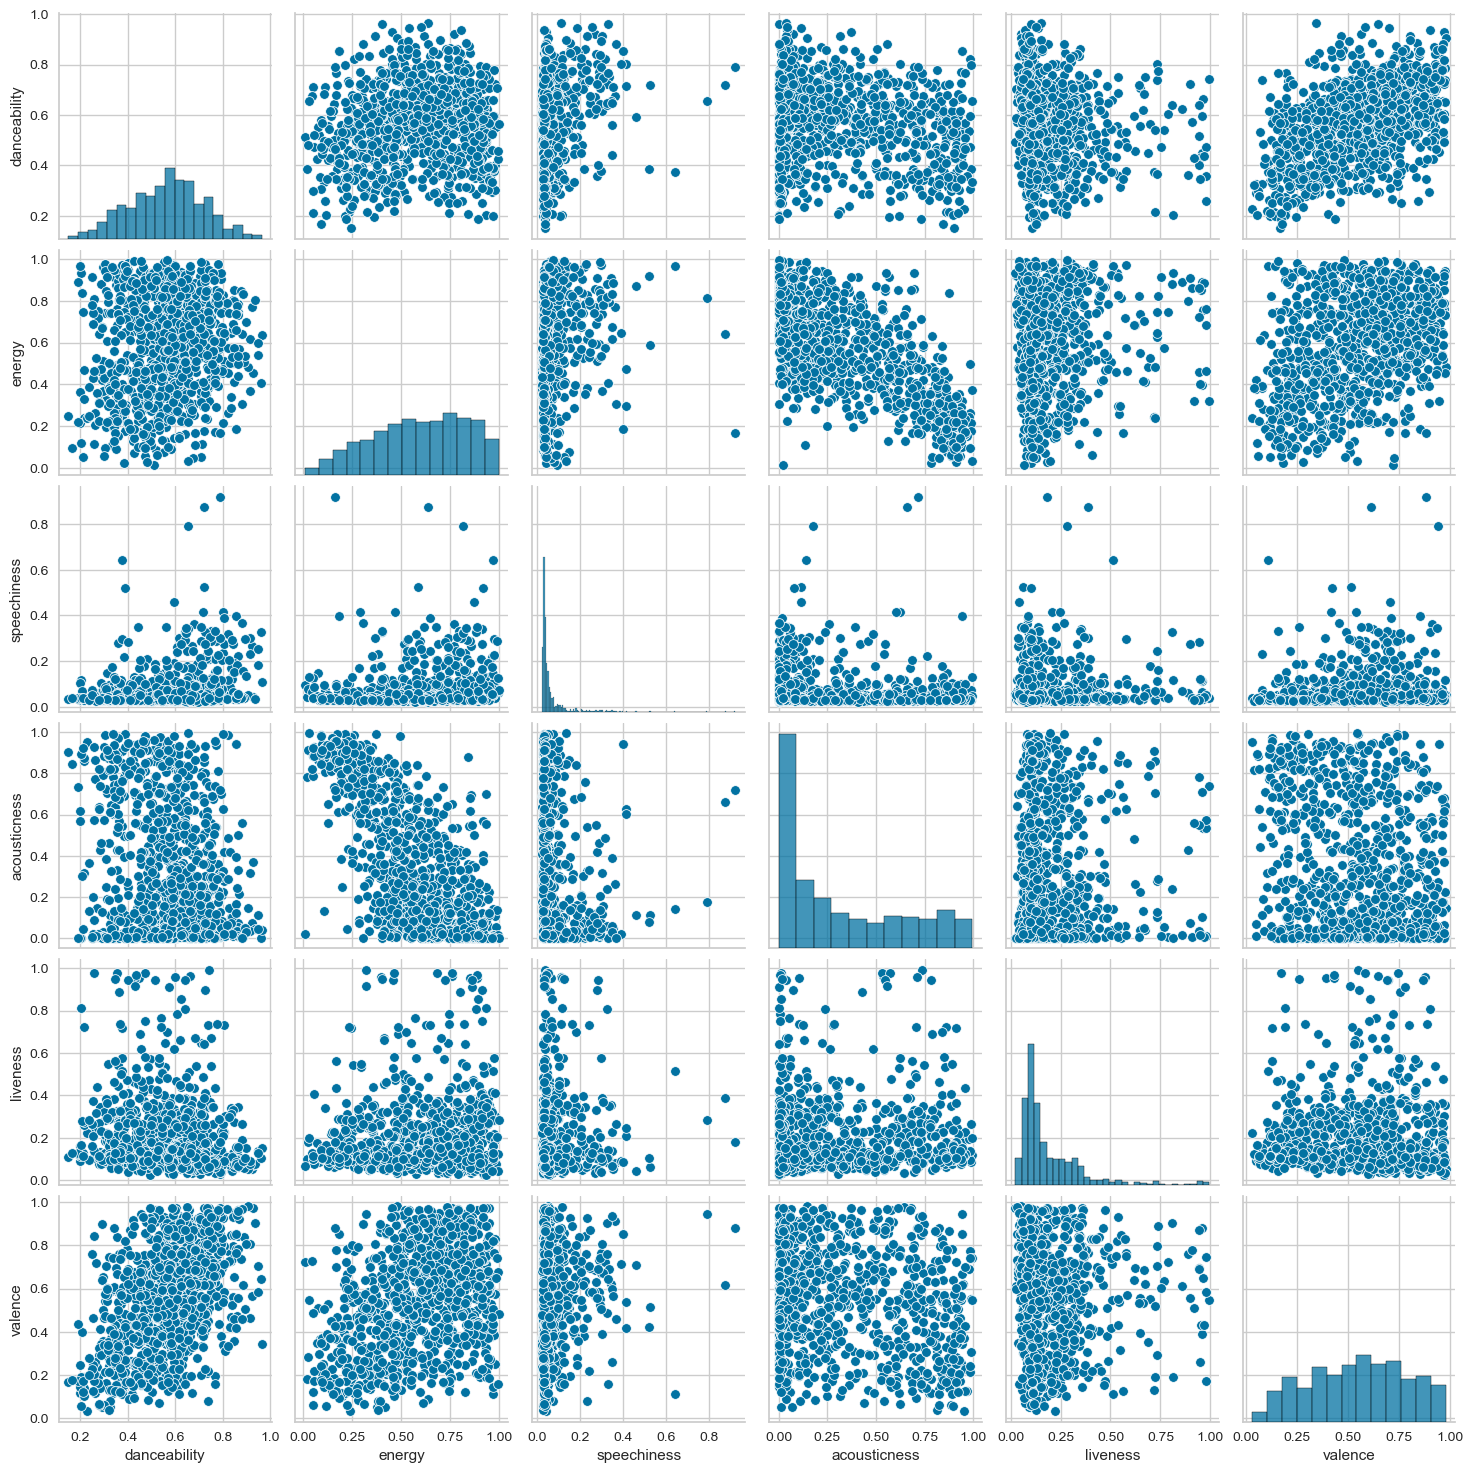

In [5]:
# getting the songs attrbute pairplot
# pairplot will take a lot of time to run with large data sets, so we are going to use only 1000 samples
sample_songs_set = songs_set.sample(n=1000, random_state=42)
sns.pairplot(sample_songs_set[['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']])
plt.show()

### Find cluster model for based-line Roberta model embeddings

In [6]:
# transform lyrics to vector embedding
# get the vector embedding of the sampling 1000 dataset from the 100k songs data >> preprocess_lyrics.ipynb
with open('../App_stcloud/pickle_objects/embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

with open('../App_stcloud/pickle_objects/arr_lyrics_idx_test.pickle', 'rb') as f:
    arr_lyrics_idx = pickle.load(f)
embeddings, arr_lyrics_idx

(tensor([[-0.0182,  0.0085, -0.0229,  ...,  0.0511, -0.0479, -0.0188],
         [ 0.0051,  0.0670, -0.0593,  ..., -0.0123,  0.0548,  0.0080],
         [ 0.0112,  0.0435, -0.0335,  ..., -0.0679,  0.0311,  0.0016],
         ...,
         [-0.0064, -0.0010,  0.0143,  ...,  0.0484, -0.0303, -0.0150],
         [-0.0088, -0.0380,  0.0079,  ..., -0.0286,  0.0250,  0.0096],
         [ 0.0156, -0.0327, -0.0249,  ..., -0.0329,  0.0014, -0.0077]]),
 array(['Break Apart Her Heart Lyrics[Verse 1]',
        "When you call, she doesn't answer",
        "When you write, she doesn't answer", ..., '[Outro:]',
        'Not knowing how I got there or how to leave',
        'Not knowing how I got there or how to leaveEmbed'], dtype='<U2420'))

In [7]:
embeddings.shape

torch.Size([166075, 768])

In [8]:
embeddings_df = pd.DataFrame(embeddings); embeddings_df.shape
embeddings_df = embeddings_df.dropna(); embeddings_df.shape 
embeddings = embeddings_df.to_numpy(); embeddings.shape


(166075, 768)

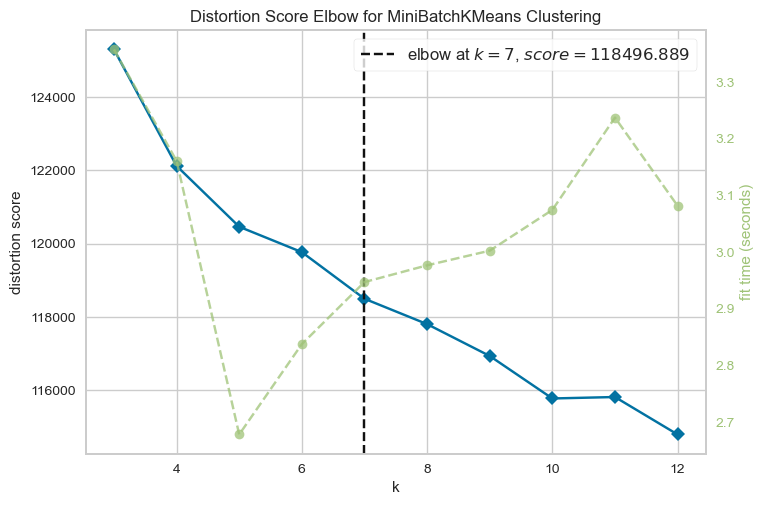

<AxesSubplot: title={'center': 'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
X = embeddings
model = MiniBatchKMeans(init='k-means++', max_iter=300, random_state=42, batch_size=2048)
visualizer = KElbowVisualizer(model, k=(3,13))
visualizer.fit(X)
visualizer.show()

In [10]:
# model = MiniBatchKMeans(n_clusters=8, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [11]:
kmeans = MiniBatchKMeans(n_clusters=7, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
labels = kmeans.fit_predict(X)
embeddings_df['label'] = labels; embeddings_df.head(3)
embeddings_df['lyrics_line'] = arr_lyrics_idx; embeddings_df.head(3)


# save the clustering model to a file
with open('../App_stcloud/pickle_objects/cluster_model.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [12]:
embeddings_df.shape

(166075, 770)

In [13]:
# using PCA to reduce the dimension of the embeddings
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(X), columns=['component1','component2'])
pca_df['cluster'] = labels
pca_df['lyrics'] = arr_lyrics_idx; pca_df.head()

sample_pca_df = pca_df.sample(n=3000, random_state=42)

# dump pca model to file
with open('../App_stcloud/pickle_objects/pca_model.pickle', 'wb') as f:
    pickle.dump(pca, f)
# dump the sample pca to a pickle file
with open('../App_stcloud/pickle_objects/sampling_cluster.pickle', 'wb') as f:
    pickle.dump(sample_pca_df, f)

In [14]:
alt.themes.enable('default')
chart1 = alt.Chart(sample_pca_df).mark_circle().encode(
    x=alt.X('component1:Q'),
    y=alt.Y('component2:Q'),
    color=alt.Color('cluster:O', scale=alt.Scale(scheme='tableau10')),
    tooltip=['lyrics', 'cluster']
)

chart1

alt.Chart(...)

In [15]:
query = 'Happy'
model = SentenceTransformer("all-distilroberta-v1")
input_emb = model.encode(query, convert_to_numpy=True)
input_emb = input_emb.reshape(1,-1)

In [16]:
pca_df = pd.DataFrame(pca.transform(input_emb), columns=['component1', 'component2'])
pca_df['query'] = query

In [17]:
chart2 = alt.Chart(pca_df).mark_square(size=80, color='red').encode(
    x=alt.X('component1:Q'),
    y=alt.Y('component2:Q'),
    tooltip='query'
)

In [18]:
(chart1 + chart2).interactive()

alt.LayerChart(...)

In [19]:
with open('../App_stcloud/pickle_objects/sampling_cluster.pickle', 'rb') as f:
    df = pickle.load(f)

#### Find cluster model for fine-tune embeddings

In [20]:
embeddings_df = pd.DataFrame(embeddings); embeddings_df.shape
embeddings_df = embeddings_df.dropna(); embeddings_df.shape 
embeddings = embeddings_df.to_numpy(); embeddings.shape

(166075, 768)

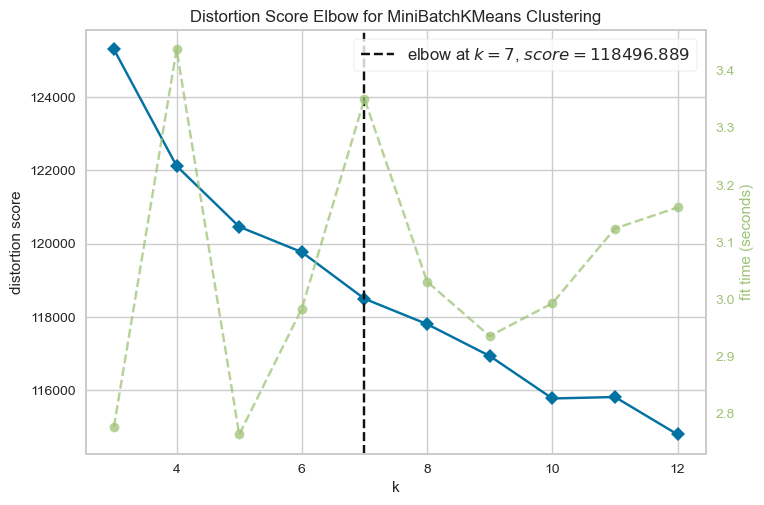

In [21]:
X = embeddings
model = MiniBatchKMeans(init='k-means++', max_iter=300, random_state=42, batch_size=2048)
visualizer = KElbowVisualizer(model, k=(3,13))
visualizer.fit(X)
visualizer.show()
k = visualizer.elbow_value_

In [22]:
kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
labels = kmeans.fit_predict(X)
embeddings_df['label'] = labels; embeddings_df.head(3)
embeddings_df['lyrics_line'] = arr_lyrics_idx; embeddings_df.head(3)


# save the clustering model to a file
with open('../App_stcloud/pickle_objects/cluster_model_test.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [23]:
# using PCA to reduce the dimension of the embeddings
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(X), columns=['component1','component2'])
pca_df['cluster'] = labels
pca_df['lyrics'] = arr_lyrics_idx; pca_df.head()

sample_pca_df = pca_df.sample(n=3000, random_state=42)

# dump pca model to file
with open('../App_stcloud/pickle_objects/pca_model_test.pickle', 'wb') as f:
    pickle.dump(pca, f)
# dump the sample pca to a pickle file
with open('../App_stcloud/pickle_objects/sampling_cluster_test.pickle', 'wb') as f:
    pickle.dump(sample_pca_df, f)